# **Install Required Libraries**

In [6]:
!pip install shap lime xgboost
!pip install shap lime xgboost folium scikit-learn

# **Import and Data Loading**

In [7]:
import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Uploading the file:
from google.colab import files
print("Please upload 'crime_data.csv' now.")
uploaded = files.upload()

# Load and basic clean
data = pd.read_csv('crime_data.csv')
print(f"Dataset Loaded: {data.shape[0]} rows")

Please upload 'crime_data.csv' now.


Saving crime_data.csv to crime_data.csv
Dataset Loaded: 239558 rows


# **Research-Grade Feature Engineering**

In [8]:
# 1. Temporal Processing
# Converting date strings to datetime objects
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date', 'Latitude', 'Longitude'], inplace=True)

# Cyclical Encoding: Hour 23 and Hour 0 are now adjacent in the model's eyes
data['hour'] = data['Date'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24.0)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24.0)

# Day and Month features
data['weekday'] = data['Date'].dt.weekday
data['month'] = data['Date'].dt.month

# 2. Spatial Hotspot Clustering
# Clustering latitudes and longitudes into 12 distinct 'Crime Zones'
coords = data[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10).fit(coords)
data['zone_id'] = kmeans.labels_

# 3. Target Definition
# Binary classification: 1 for Violent/Theft (High Risk), 0 for others
data['target'] = np.where(data['Primary Type'].isin(['BATTERY', 'THEFT', 'ROBBERY', 'ASSAULT']), 1, 0)

# Final Feature Selection
features = ['Latitude', 'Longitude', 'hour_sin', 'hour_cos', 'weekday', 'month', 'zone_id']
X = data[features]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Feature Engineering Complete.")

Feature Engineering Complete.


# **Model Training & Evaluation**

In [9]:
# Training XGBoost (Research standard for tabular data)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Metrics
preds = xgb_model.predict(X_test)
print("--- Model Performance ---")
print(classification_report(y_test, preds))

--- Model Performance ---
              precision    recall  f1-score   support

           0       0.56      0.42      0.48     22122
           1       0.58      0.70      0.63     24857

    accuracy                           0.57     46979
   macro avg       0.57      0.56      0.56     46979
weighted avg       0.57      0.57      0.56     46979



# **Spatial Visualization (Folium Map)**

In [10]:
def generate_crime_map(df):
    # Center map on Chicago averages
    chicago_map = folium.Map(location=[df.Latitude.mean(), df.Longitude.mean()], zoom_start=11)

    # Filter only High Risk crimes for the heatmap
    heat_data = [[row['Latitude'], row['Longitude']] for _, row in df[df['target']==1].iterrows()]

    HeatMap(heat_data, radius=15, blur=10).add_to(chicago_map)
    return chicago_map

# Display map for a sample of the data
m = generate_crime_map(data.sample(1000))
m.save('crime_analysis_map.html')
m

# **Explainable AI (SHAP)**

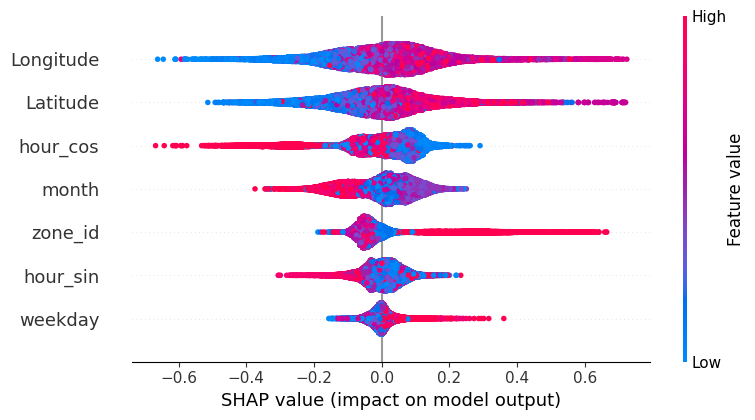

In [11]:
# SHAP Global Interpretation
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, feature_names=features)